In [1]:
from random import seed
from random import randrange
from random import random
from random import shuffle
from csv import reader
from math import exp
from numpy import var
import matplotlib.pyplot as plt
import csv

In [2]:
def initialize_network_hidden(n_inputs, n_hidden):
    hidden_layer=[{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    return hidden_layer

In [3]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer=[{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden[0])]
    network.append(hidden_layer)
    if len(n_hidden)!=1:
        for i in range(len(n_hidden)-1):
            hidden_layer = initialize_network_hidden(n_inputs=n_hidden[i],n_hidden=n_hidden[i+1])
            network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range((n_hidden[len(n_hidden)-1]) + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
#     for line in network:
#         print(line,'\r')
#     print('\n')
    return network

In [4]:
# Load a CSV file
def load_csv(filename, seeds=False, iris=False):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            if(seeds):
                row=' '.join(row)
                row = row.replace('\t', ',')
            if(iris):
                row=','.join(row)
            row.split(',')
            dataset.append(row)
    return dataset

In [5]:
# activation = sum(weight_i * input_i) + bias

# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

In [6]:
# output = 1 / (1 + e^(-activation))
# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

In [7]:
# Forward propagate input to a network output
# Прямое распространение ввода на сетевой выход
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [8]:
# derivative = output * (1.0 - output)
# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

In [9]:
# Считаем ошибку для каждого выходного нейрона (output)
# error = (expected - output) * transfer_derivative(output)

# Для скрытого слоя (hidden)
# error = (weight_k * error_j) * transfer_derivative(output)

# error_j - это сигнал ошибки от j- го нейрона в выходном слое
# weight_k - это вес, который соединяет k- й нейрон с текущим нейроном
# output - выход для текущего нейрона.

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [10]:
# Обновление массы весов с помощью полученных ошибок
# weight = weight + learning_rate * error * input
# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

In [11]:
# Train a network for a fixed number of epochs
def train_network(network, train, test, l_rate, n_epoch, n_outputs, shuffle_):
    epoch_=[]
    sum_error=[]
    sum_error_=[]
    for epoch in range(n_epoch):
        sum_error_train = 0
        sum_error_test = 0
        if shuffle_:
            shuffle(train)
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error_train += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
            
        for row in test:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error_test += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
        
        epoch_.append(epoch)
        sum_error.append(sum_error_train)
        sum_error_.append(sum_error_test)
#         print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    plt.figure(figsize=(20,10))
    plt.plot(epoch_,sum_error,'ro',label='sum_error_train')
    plt.plot(epoch_,sum_error_,'go',label='sum_error_test')
    plt.xlabel('EPOCH')
    plt.ylabel('sum_error')
    plt.title('multilayer perceptron')
    plt.legend(loc=0)    

In [12]:
# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

In [13]:
# Convert string column to float
def str_column_to_float(row):
    row = [float(row) for row in row.split(',')]
    return row

In [14]:
# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

In [15]:
def iris_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

In [16]:
# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

In [17]:
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [18]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [19]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    predicted_=list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, fold, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [21]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, fold, l_rate, n_epoch, n_hidden, sh):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, fold, l_rate, n_epoch, n_outputs,shuffle_=sh)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

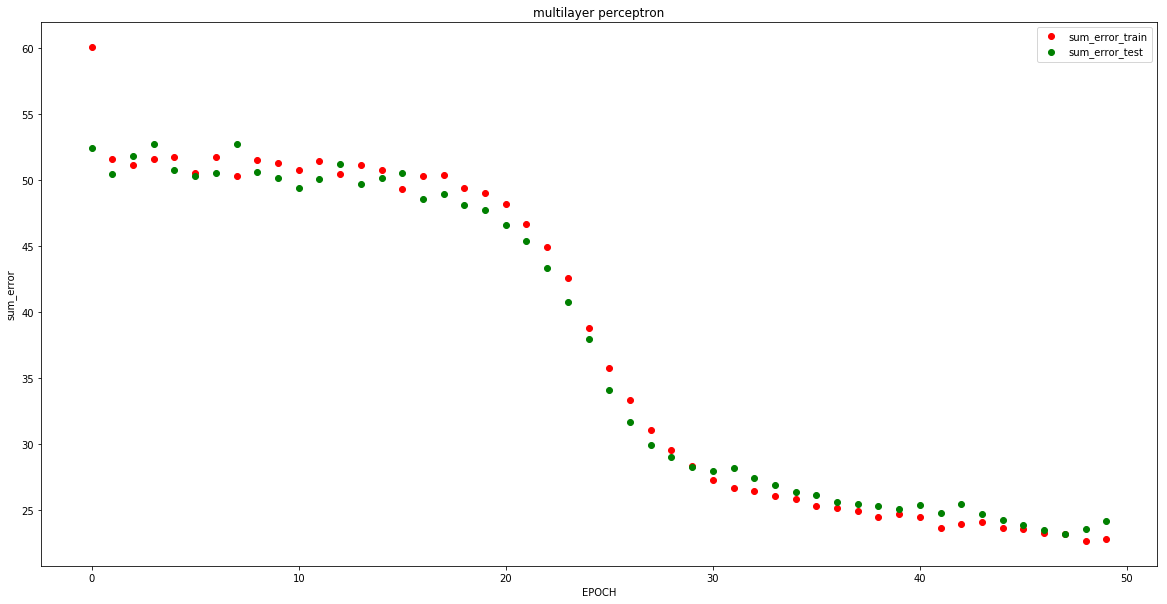

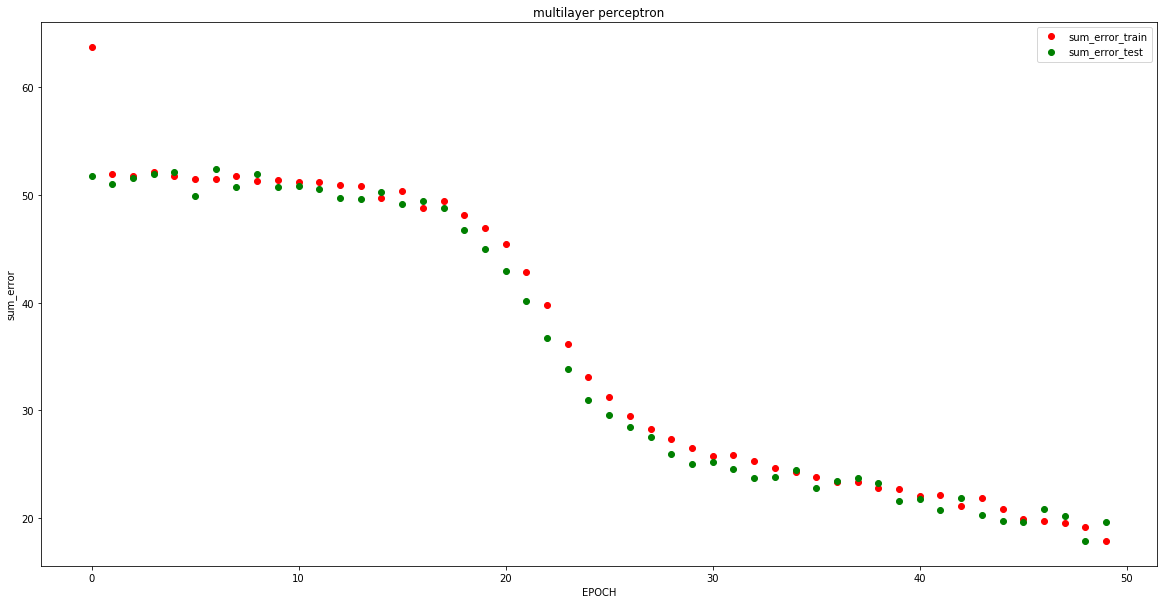

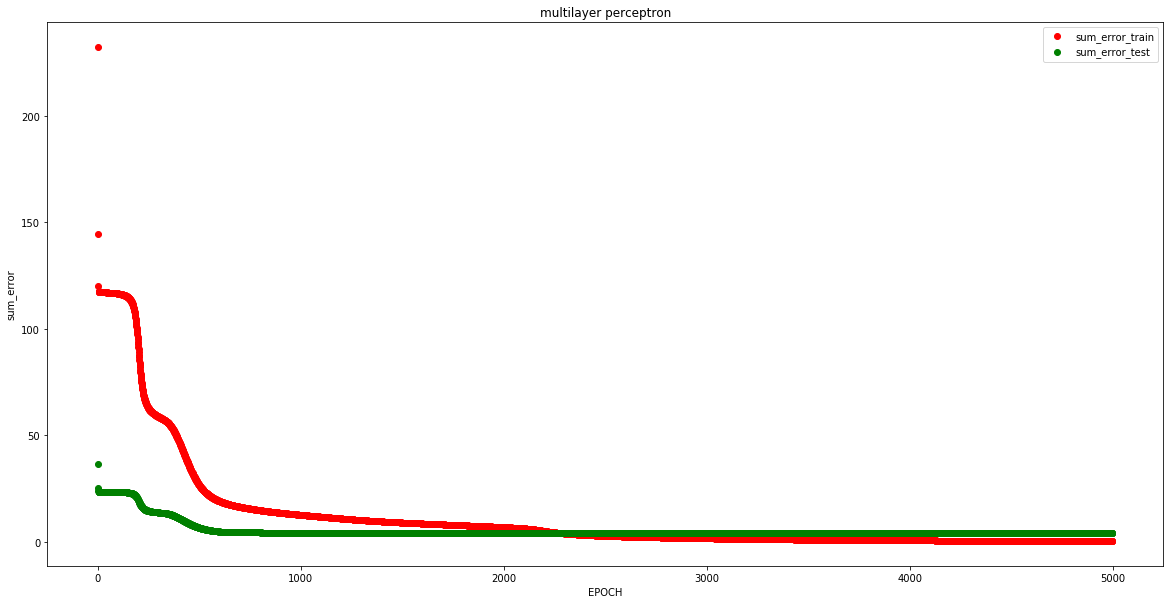

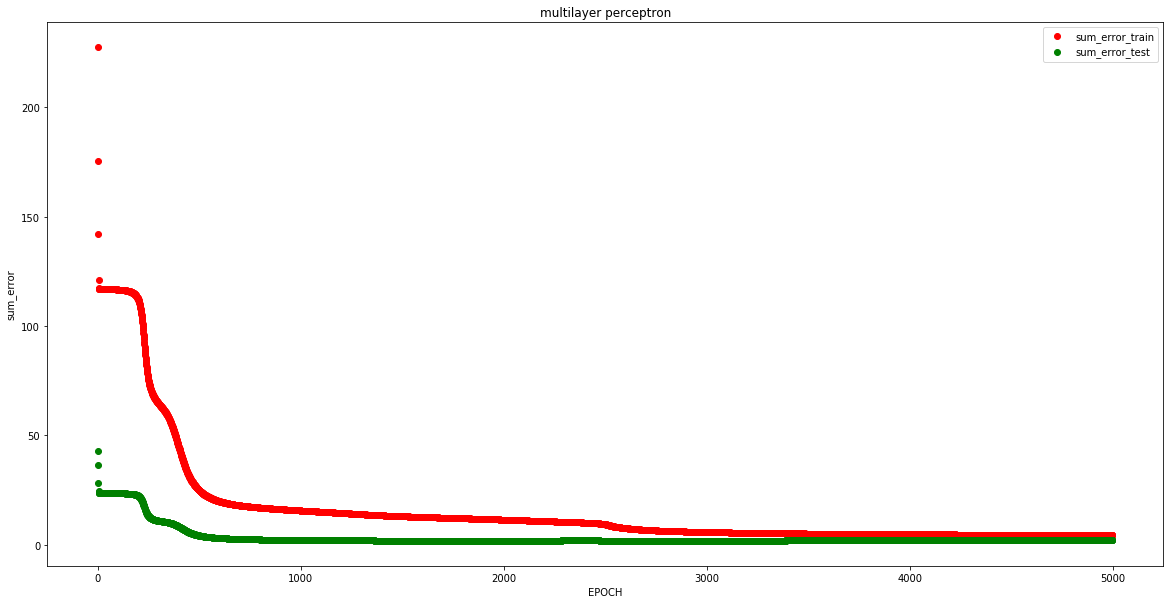

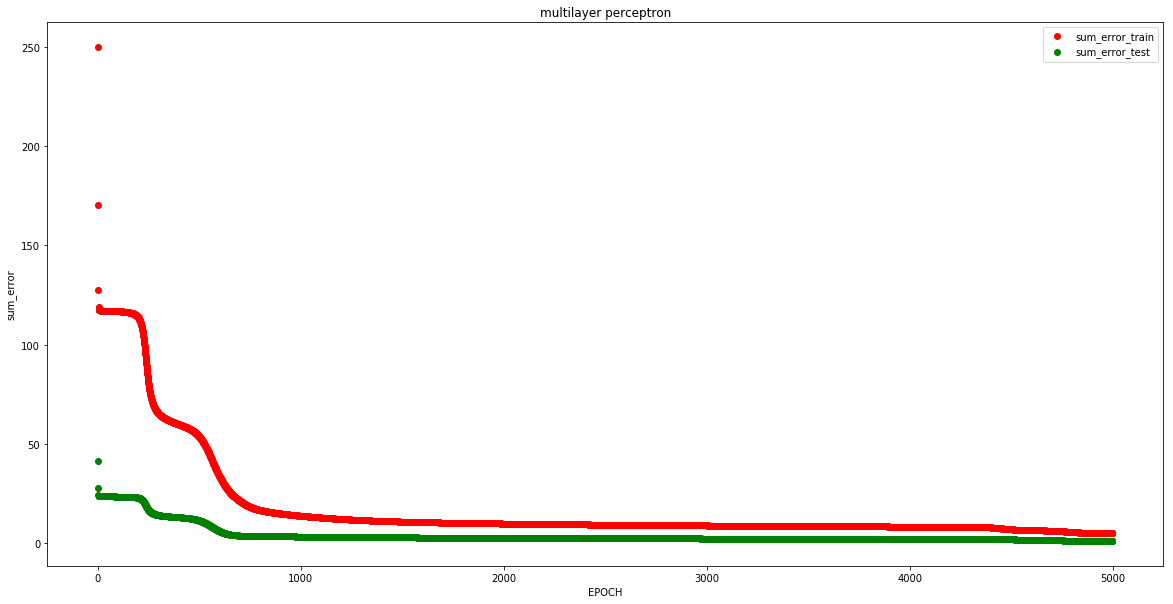

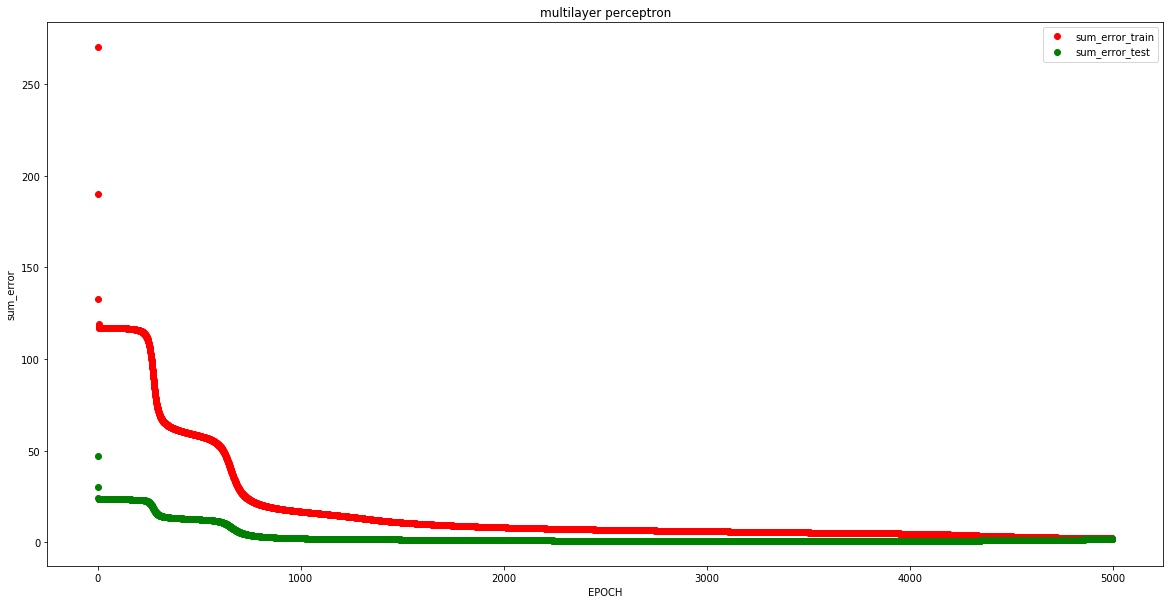

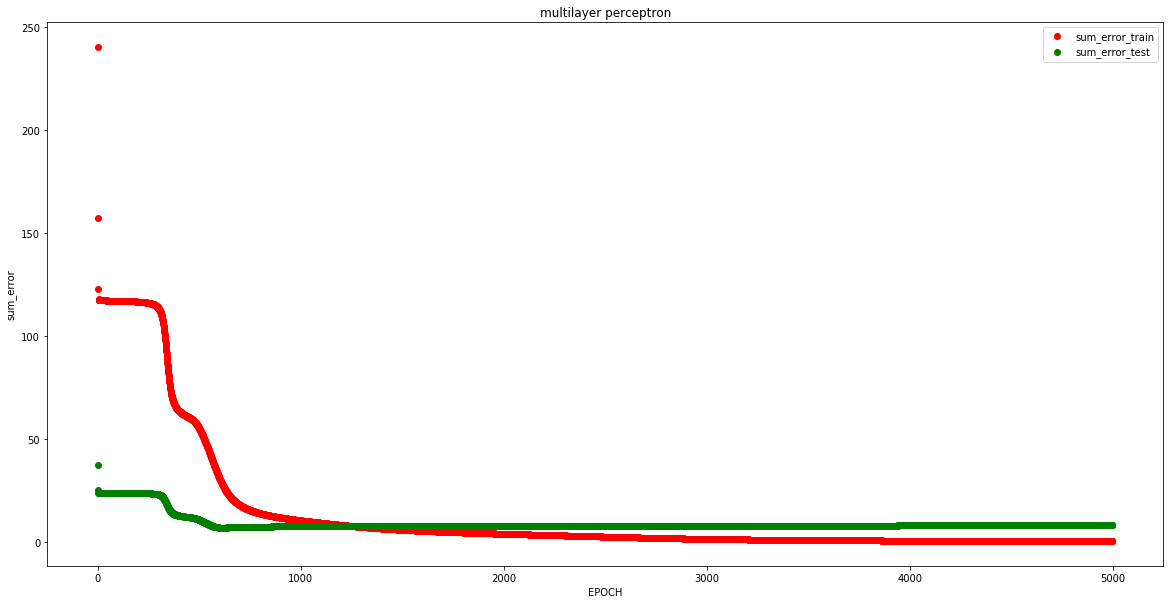

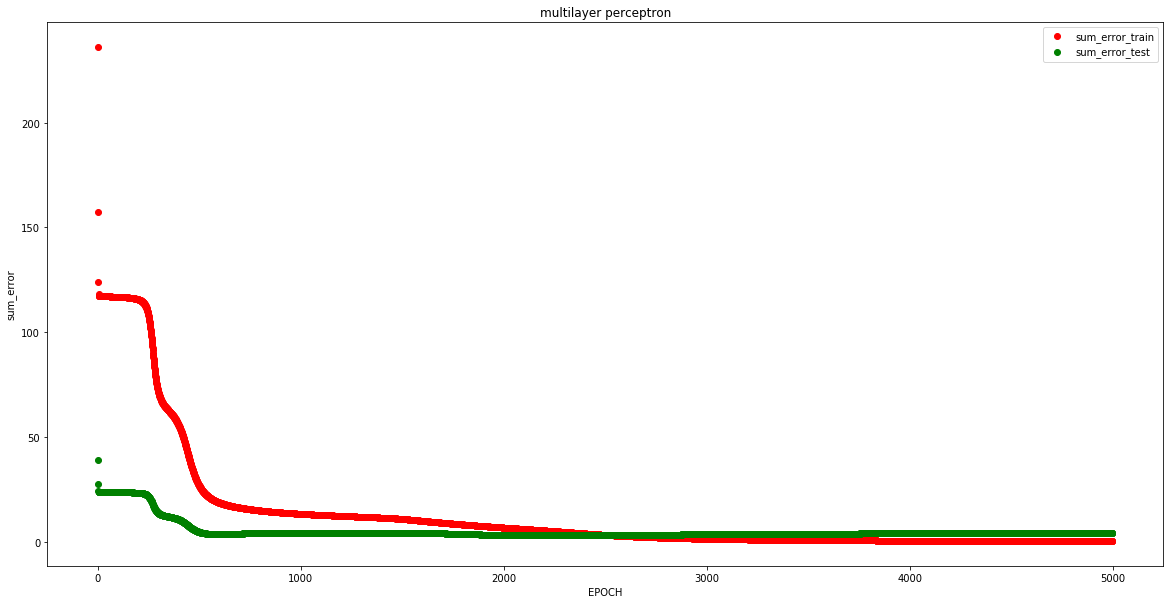

Scores: [94.28571428571428, 97.14285714285714, 97.14285714285714, 94.28571428571428, 88.57142857142857, 91.42857142857143]
Mean Accuracy: 93.810%


In [24]:
seed(1)
filename='seeds_dataset_1.csv'
dataset=load_csv(filename, True)
for i, row in enumerate(dataset):
    dataset[i]=str_column_to_float(row)
str_column_to_int(dataset, len(dataset[0])-1)
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
n_folds = 6
l_rate = 0.03
n_epoch = 5000
n_hidden = [4,3]
shuffle(dataset)
scores = evaluate_algorithm(dataset,back_propagation, n_folds, l_rate, n_epoch, n_hidden, False)
plt.show()
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

In [23]:
seed(1)
filename_='iris.csv'
dataset_=load_csv(filename_,iris=True)
for i, row in enumerate(dataset_):
    dataset_[i]=str_column_to_float(row)
# iris_column_to_int(dataset_, len(dataset_[0])-1)
str_column_to_int(dataset_, len(dataset_[0])-1)
minmax = dataset_minmax(dataset_)
normalize_dataset(dataset_, minmax)
n_folds = 2
l_rate = 0.4
n_epoch = 50
n_hidden = [4,3]
scores = evaluate_algorithm(dataset_,back_propagation, n_folds, l_rate, n_epoch, n_hidden, True)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [82.66666666666667, 92.0]
Mean Accuracy: 87.333%
